# 03.2 Confidence Intervals: What They Actually Mean

**Chapter**: 3 - Stats Review  
**Section**: 2 - Confidence Intervals  
**Facure Source**: 03-Stats-Review-The-Most-Dangerous-Equation.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Frequentist Worldview](#11-the-frequentist-worldview)
   - 1.2 [Plato's Forms](#12-platos-forms)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Central Limit Theorem](#21-central-limit-theorem)
   - 2.2 [CI Construction](#22-ci-construction)
   - 2.3 [Correct Interpretation](#23-correct-interpretation)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Building CIs from Scratch](#31-building-cis-from-scratch)
   - 3.2 [The Coverage Property](#32-the-coverage-property)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)
from scipy import stats

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: CI interpretation is a classic interview question. Many candidates (and practitioners) get it wrong. Understanding the frequentist interpretation separates strong candidates.

### 1.1 The Frequentist Worldview

Facure uses Plato's allegory of the cave:

- **True parameter** (μ): Like Plato's Forms, it exists but we never see it directly
- **Sample mean** (x̄): A shadow on the cave wall—an imperfect reflection
- **Repeated sampling**: Each time we sample, we get a different shadow

### 1.2 Plato's Forms

The frequentist view:
- The true mean **exists** and is **fixed** (not random)
- Our **estimate** is random (changes with each sample)
- A CI quantifies the **range of plausible estimates**, not the range of the parameter

★ Insight ─────────────────────────────────────
- The 95% in a 95% CI refers to the **procedure**, not this specific interval
- If we repeated the study infinitely, 95% of intervals would contain μ
- Once computed, a specific CI either contains μ (100%) or doesn't (0%)
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Central Limit Theorem

**Theorem (CLT)**: Let $X_1, \ldots, X_n$ be iid with mean $\mu$ and variance $\sigma^2$. Then:

$$\frac{\bar{X} - \mu}{\sigma/\sqrt{n}} \xrightarrow{d} N(0, 1)$$

as $n \to \infty$.

**Implication**: Sample means are approximately normal, regardless of the underlying distribution.

### 2.2 CI Construction

For a $(1-\alpha)$ confidence interval:

$$\boxed{CI = \bar{X} \pm z_{\alpha/2} \cdot \frac{\hat{\sigma}}{\sqrt{n}}}$$

where:
- $z_{\alpha/2}$ = critical value (1.96 for 95%, 2.576 for 99%)
- $\hat{\sigma}/\sqrt{n}$ = standard error

**Common critical values**:

| Confidence | $\alpha$ | $z_{\alpha/2}$ |
|------------|----------|----------------|
| 90% | 0.10 | 1.645 |
| 95% | 0.05 | 1.960 |
| 99% | 0.01 | 2.576 |

### 2.3 Correct Interpretation

**WRONG**: "There is a 95% probability that μ is in this interval"
- This implies μ is random. It's not—μ is fixed.

**RIGHT**: "If we repeated this procedure many times, 95% of the resulting intervals would contain μ"
- This describes the procedure's long-run frequency.

**Also RIGHT**: "We are 95% confident that μ lies in this interval"
- "Confident" is a statement about the method, not about probability.

---

## 3. Numeric Demonstration

### 3.1 Building CIs from Scratch

In [2]:
# Load online classroom data (Facure's example)
classroom = load_facure_data('online_classroom.csv')

# Split by format
online = classroom.query('format_ol == 1')['falsexam']
face_to_face = classroom.query('format_ol == 0 and format_blended == 0')['falsexam']

print("ONLINE CLASSROOM DATA")
print("="*50)
print(f"Online students:      n = {len(online)}")
print(f"Face-to-face:         n = {len(face_to_face)}")

ONLINE CLASSROOM DATA
Online students:      n = 94
Face-to-face:         n = 120


In [3]:
def compute_ci(data, confidence=0.95):
    """Compute confidence interval from scratch."""
    n = len(data)
    mean = np.mean(data)
    se = np.std(data, ddof=1) / np.sqrt(n)
    
    # Critical value from standard normal
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    
    ci_lower = mean - z * se
    ci_upper = mean + z * se
    
    return {
        'mean': mean,
        'se': se,
        'z': z,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'width': ci_upper - ci_lower,
    }

# Compute CIs for both groups
ci_online = compute_ci(online)
ci_f2f = compute_ci(face_to_face)

print("CONFIDENCE INTERVALS (95%)")
print("="*60)
print(f"{'Group':<15} {'Mean':>8} {'SE':>8} {'CI Lower':>10} {'CI Upper':>10}")
print("-"*60)
print(f"{'Online':<15} {ci_online['mean']:>8.2f} {ci_online['se']:>8.2f} {ci_online['ci_lower']:>10.2f} {ci_online['ci_upper']:>10.2f}")
print(f"{'Face-to-Face':<15} {ci_f2f['mean']:>8.2f} {ci_f2f['se']:>8.2f} {ci_f2f['ci_lower']:>10.2f} {ci_f2f['ci_upper']:>10.2f}")
print("\nNote: These CIs don't overlap → suggests significant difference")

CONFIDENCE INTERVALS (95%)
Group               Mean       SE   CI Lower   CI Upper
------------------------------------------------------------
Online             73.64     1.54      70.62      76.65
Face-to-Face       78.55     0.87      76.84      80.26

Note: These CIs don't overlap → suggests significant difference


### 3.2 The Coverage Property

In [4]:
# Demonstrate what "95% confidence" actually means
np.random.seed(42)

# True parameter (this is what we're trying to estimate)
true_mu = 75
true_sigma = 15
n_per_sample = 50

# Run 100 "studies"
n_studies = 100
cis = []
for _ in range(n_studies):
    sample = np.random.normal(true_mu, true_sigma, n_per_sample)
    ci = compute_ci(sample, confidence=0.95)
    ci['contains_mu'] = ci['ci_lower'] <= true_mu <= ci['ci_upper']
    cis.append(ci)

cis_df = pd.DataFrame(cis)
coverage = cis_df['contains_mu'].mean()

print(f"COVERAGE DEMONSTRATION")
print(f"="*50)
print(f"True μ: {true_mu}")
print(f"Number of studies: {n_studies}")
print(f"CIs containing true μ: {cis_df['contains_mu'].sum()}/{n_studies} = {coverage:.0%}")

COVERAGE DEMONSTRATION
True μ: 75
Number of studies: 100
CIs containing true μ: 94/100 = 94%


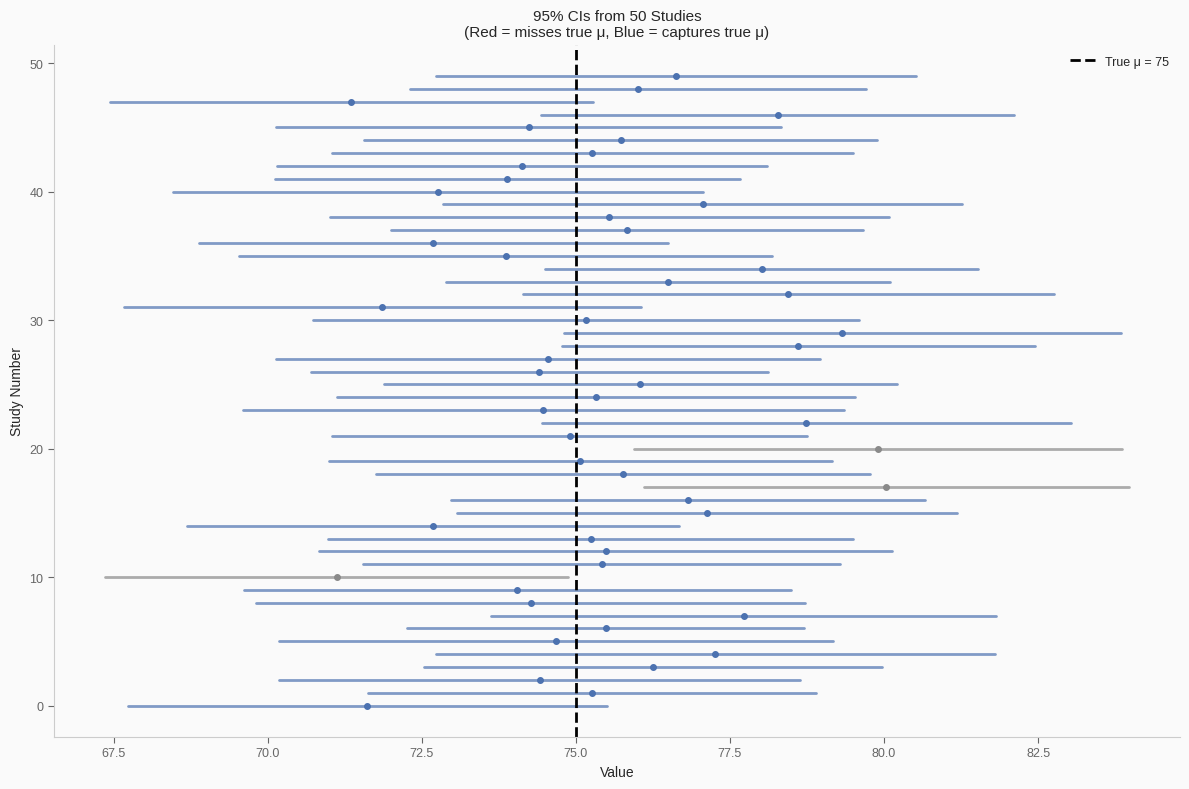


Interpretation: About 95% of intervals (blue) contain the true parameter.
The ~5% that miss (red) are expected—that's what '95% confidence' means.


In [5]:
# Visualize the coverage property
fig, ax = create_tufte_figure(1, 1, figsize=(12, 8))

# Show first 50 CIs
n_show = 50
for i, row in cis_df.head(n_show).iterrows():
    color = TUFTE_PALETTE['treatment'] if row['contains_mu'] else TUFTE_PALETTE['control']
    ax.plot([row['ci_lower'], row['ci_upper']], [i, i], 
            color=color, linewidth=2, alpha=0.7)
    ax.plot(row['mean'], i, 'o', color=color, markersize=4)

# True mean
ax.axvline(true_mu, color='black', linestyle='--', linewidth=2, label=f'True μ = {true_mu}')

ax.set_xlabel('Value')
ax.set_ylabel('Study Number')
ax.set_title(f'95% CIs from {n_show} Studies\n(Red = misses true μ, Blue = captures true μ)')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print(f"\nInterpretation: About 95% of intervals (blue) contain the true parameter.")
print(f"The ~5% that miss (red) are expected—that's what '95% confidence' means.")

---

## 4. Implementation

```python
from scipy import stats

# Method 1: Manual construction
mean = data.mean()
se = data.std(ddof=1) / np.sqrt(len(data))
ci = (mean - 1.96*se, mean + 1.96*se)

# Method 2: Using scipy
ci = stats.t.interval(0.95, df=len(data)-1, 
                      loc=mean, scale=se)

# Method 3: Using statsmodels
import statsmodels.stats.api as sms
ci = sms.DescrStatsW(data).tconfint_mean()
```

For treatment effects, use the Neyman variance formula (see 03.1).

---

## 5. Interview Appendix

**Q1**: *"How do you interpret a 95% confidence interval?"*

<details><summary>Solution</summary>

**Correct**: "If we repeated this procedure many times, 95% of the resulting intervals would contain the true parameter."

**Also acceptable**: "We are 95% confident that the true parameter lies in this interval."

**WRONG (common mistake)**: "There is a 95% probability that the true parameter is in this interval." This implies the parameter is random—it's not.

The key insight: The 95% describes the **procedure's reliability**, not the probability that any specific interval is correct.

</details>

**Q2**: *"If two 95% CIs don't overlap, what can you conclude?"*

<details><summary>Solution</summary>

Non-overlapping CIs **do** imply statistical significance at the 5% level, but with caveats:

1. **Conservative test**: Non-overlapping CIs is MORE conservative than a direct hypothesis test
2. **Overlapping CIs ≠ no significance**: Two CIs can overlap yet the difference can still be significant
3. **Better approach**: Compute a CI for the difference directly

The SE of a difference is: SE(diff) = √(SE₁² + SE₂²)

This is **smaller** than using the union of individual CIs, so direct testing is more powerful.

</details>

**Q3**: *"Why do we need confidence intervals? Why not just report the point estimate?"*

<details><summary>Solution</summary>

CIs provide **uncertainty quantification**:

1. **Sample size awareness**: Wide CIs signal small samples
2. **Precision communication**: Shows estimate reliability
3. **Decision-making**: Can the interval include zero? Includes effect of interest?
4. **Replication insight**: Other studies should fall within CI most of the time

Example: "ATE = 5" tells us nothing. "ATE = 5, 95% CI: [4.5, 5.5]" tells us it's precise. "ATE = 5, 95% CI: [-10, 20]" tells us we need more data.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 3.

[^2]: Neyman, J. (1937). Outline of a theory of statistical estimation based on the classical theory of probability. *Phil. Trans. R. Soc. A*, 236, 333-380.

[^3]: Morey, R. D., Hoekstra, R., et al. (2016). The fallacy of placing confidence in confidence intervals. *Psychonomic Bulletin & Review*, 23(1), 103-123.